# Задание 1. 
### Условие:

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)   

groups_add.csv - дополнительный файл с пользователями, который вам `прислали спустя 2 дня` после передачи данных   

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.    

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandahouse as ph
from scipy import stats
from pingouin import qqplot
from tqdm.auto import tqdm
from scipy.stats import norm

import requests
from urllib.parse import urlencode



In [2]:
path1 = 'C:\\Users\\Noblesse\\Desktop\\Jupyter_Projects\\KarpovCourse\\Final_Project\\groups.csv'
path2 = 'C:\\Users\\Noblesse\\Desktop\\Jupyter_Projects\\KarpovCourse\\Final_Project\\group_add.csv'
path3 = 'C:\\Users\\Noblesse\\Desktop\\Jupyter_Projects\\KarpovCourse\\Final_Project\\active_studs.csv'
path4 = 'C:\\Users\\Noblesse\\Desktop\\Jupyter_Projects\\KarpovCourse\\Final_Project\\checks.csv'


In [3]:
groups_df       = pd.read_csv(path1, sep=';')
groups_add_df   = pd.read_csv(path2)
active_studs_df = pd.read_csv(path3)
checks_df       = pd.read_csv(path4, sep=';')

Проверим все таблицы на наличие пропусков и дубликатов:

In [4]:
l = [groups_df, groups_add_df, active_studs_df, checks_df]
names = ['groups_df', 'groups_add_df', 'active_studs_df', 'checks_df']

for n, i in enumerate(l):
    print(f"{n+1}.{names[n]}\n{i.shape}")
    print(f"Дубликаты: {len(i) > len(i.drop_duplicates())}\n")
    print(f"Пропуски:\n{i.isna().sum()}\n")
    print(f"Типы данных:\n{i.dtypes}.\n------------------")

    


1.groups_df
(74484, 2)
Дубликаты: False

Пропуски:
id     0
grp    0
dtype: int64

Типы данных:
id      int64
grp    object
dtype: object.
------------------
2.groups_add_df
(92, 2)
Дубликаты: False

Пропуски:
id     0
grp    0
dtype: int64

Типы данных:
id      int64
grp    object
dtype: object.
------------------
3.active_studs_df
(8341, 1)
Дубликаты: False

Пропуски:
student_id    0
dtype: int64

Типы данных:
student_id    int64
dtype: object.
------------------
4.checks_df
(541, 2)
Дубликаты: False

Пропуски:
student_id    0
rev           0
dtype: int64

Типы данных:
student_id      int64
rev           float64
dtype: object.
------------------


Посмотрим на количество уникальных пользователей и на размеры групп:


In [5]:
groups_df.head(1)

,id,grp
0,1489,B


In [6]:
print(groups_df.id.nunique())
print(groups_df.grp.value_counts())

74484
B    59813
A    14671
Name: grp, dtype: int64


In [7]:
# посмотрим на процент пользователей в контрольной группе
14671/74484 * 100

19.69684764513184

**_Мы видим довольно большую разницу в количестве пользователей в группах - соотношение около 20/80, причем 20% пользователей в контрольной группе, что очень странно. Обычно мы хотим или равные группы в АБ тесте, или же если мы хотим протестировать изменения с меньшим риском, мы делаем тестовую группу меньше. Здесь же количество пользователей в тестовой группе является большинством. На этом этапе я бы спросил чем вызвано такое разделение на группы._**

Объединим наш основной датафрейм с дополнительным файлом, который прислали спустя 2 дня:

In [8]:
frames = [groups_df, groups_add_df]

all_users_df = pd.concat(frames, ignore_index=True)
all_users_df.shape

(74576, 2)

Переименуем колонки, чтобы объединить таблицу активных студентов с таблицей всех пользователей, и объединим:

In [9]:
active_studs_df = active_studs_df.rename(columns={'student_id': 'id'})

active_groups = active_studs_df.merge(all_users_df, on='id', how='left')

print(active_groups.shape)
active_groups.head(1)


(8341, 2)


,id,grp
0,581585,A


То же самое проделаем для таблицы с оплатой:

In [10]:
checks_df = checks_df.rename(columns={'student_id': 'id'})

# сразу же заполним нулями там, где нет оплаты
full_df = active_groups.merge(checks_df, on='id', how='left').fillna(0)

full_df.head(1)

,id,grp,rev
0,581585,A,0.0


Посмотрим на количество людей в каждой группе:

In [11]:
full_df.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [12]:
1538 / (1538 + 6803)

0.18439036086800145

`Среди активных пользователей примерно такое же отношение количества людей в контрольной и тестовой группах как и среди всех пользователей.`

Посмотрим на количество платящих пользователей в каждой группе:

In [13]:
full_df.query('rev > 0') \
    .groupby('grp') \
    .id.count()

grp
A     78
B    314
Name: id, dtype: int64

## !!!

**_На данном этапе стоит отметить, что общее количество платящих пользователей которые зашли на платформу во время проведения эксперимента - 392 человека, однако в таблице с оплатой `checks_df` у нас 541 уникальных пользователей, которые совершили оплату. Это значит, что каким-то образом 149 пользователей совершили оплату при этом не заходя на платформу во время эксперимента. Эту ошибку тоже стоит уточнить._**


In [14]:
checks_df.nunique()

id     541
rev     39
dtype: int64

In [15]:
541-392

149

### Метрики для анализа.

В данном случае нам важна метрика CR - конверсия в покупку, а так же ARPPU и ARPU - средняя выручка с каждого платящего пользователя и средняя выручка со всех пользователей участвовавших в эксперименте. Проанализировав эти метрики мы сможем понять, внедрять новую систему оплаты или нет. 

### 1. Анализ CR 
Посмотрим на конверсию в покупку в обеих группах:

In [16]:
conversion_control = full_df.query('grp == "A" & rev > 0').id.count() / full_df.query('grp == "A"').id.count()
conversion_test    = full_df.query('grp == "B" & rev > 0').id.count() / full_df.query('grp == "B"').id.count()

print(f'Control: {round(conversion_control*100, 2)}%')
print(f'Test: {round(conversion_test*100,2)}%')

Control: 5.07%
Test: 4.62%


Как видим, незначительная разница в конверсии есть. Но теперь используем тест хи-квадрат, чтобы проверить статзначимы ли эти различия. 

`H0 = нет различий в CR между двумя группами.`

In [17]:
# Добавим колонку которая поделит данные на категории "оплатил" / "не оплатил"
full_df['category'] = full_df['rev'].apply(lambda x: 1 if x > 0 else 0)
full_df.tail()

,id,grp,rev,category
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1
8340,205705,B,0.0,0


In [18]:
# Используем кросстаб, чтобы создать таблицу сопряженности
contingency = pd.crosstab(full_df['grp'],full_df['category'])
contingency

category,0,1
grp,,
A,1460,78
B,6489,314


In [19]:
res = stats.chi2_contingency(contingency)
print(f'Статистика = {res.statistic}')
print(f'p-value = {res.pvalue}')

Статистика = 0.48480826522557896
p-value = 0.48625240457231045


##### Вывод: как мы видим, p-value > 0.05, поэтому мы не можем отвергнуть H0. Значимых различий в Conversion Rate между тестовой и контрольной группами нет. 

### 2. Анализ ARPPU
Теперь посмотрим на среднюю выручку в каждой группе среди платящих пользователей:

In [20]:
control_ARPPU = full_df.query('grp == "A" & rev > 0').rev
test_ARPPU = full_df.query('grp == "B" & rev > 0').rev

print(round(control_ARPPU.mean(), 2))
print(round(test_ARPPU.mean(), 2))

933.59
1257.88


In [21]:
print(round((test_ARPPU.mean() / control_ARPPU.mean() - 1)  * 100,2))

34.74


**_Мы видим довольно значительную разницу в ARPPU между двумя группами. В тестовой группе выручка выросла почти на 35%._**

Теперь давайте проверим статистически ли значимый этот результат.

Проверим данные на нормальность (H0 = данные распределены нормально):

In [22]:
print(stats.normaltest(control_ARPPU))
print(stats.normaltest(test_ARPPU))

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)
NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)


`p-value < 0.05, отклоняем нулевую гипотезу, данные распределены не нормально.`

Посмотрим на распределение на графике:

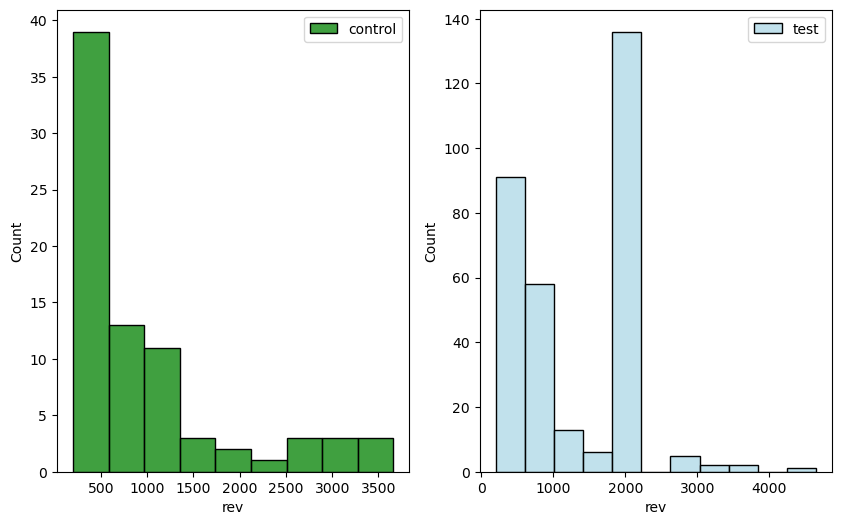

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1 = sns.histplot(control_ARPPU, ax=ax1, label = 'control', color='green')
ax2 = sns.histplot(test_ARPPU, ax=ax2, label = 'test', color='lightblue')
ax1.legend()
ax2.legend()
plt.show()

А так же посмотрим на qqplot:

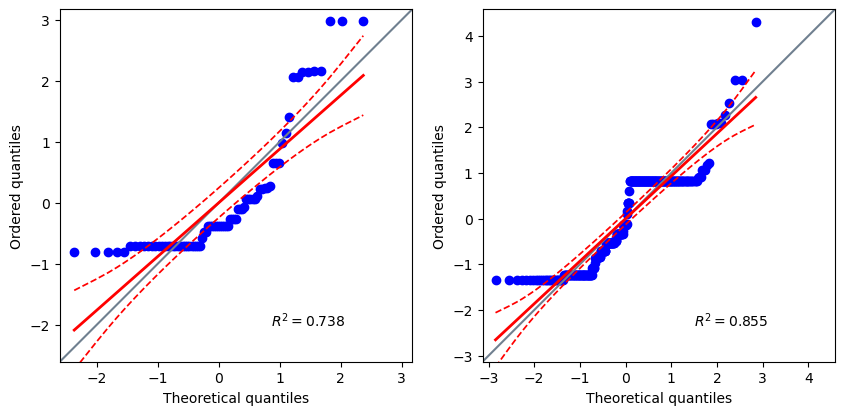

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1 = qqplot(control_ARPPU, dist='norm', ax=ax1)
ax2 = qqplot(test_ARPPU, dist='norm', ax=ax2)

Проверим являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена. Т.к. данные распределены не нормально, будем использовать параметр "median".

In [25]:
print(stats.levene(control_ARPPU, test_ARPPU, center='median'))

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)


p-value > 0.05, НЕ отклоняем нулевую гипотезу (дисперсии являются гомогенными).

**Так как наши данные имеют ненормальное распределение, а так же у нас довольно весомая разница в количестве человек в каждой группе, для проверки статзначимости мы можем использовать непараметрический критерий Манна-Уитни**

H0 = нет различий в средней выручке среди платящих пользователей пользователя между тестовой и контрольной группой.

In [26]:
stats.mannwhitneyu(control_ARPPU, test_ARPPU, alternative='two-sided')

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

`Результат теста показал p-value значительно меньше 0.05, а значит мы отклоняем нулевую гипотезу. Разница в средней выручке среди платящих пользователей между тестовой и контрольной группами есть.`

### 3. Анализ ARPU

Посмотрим на среднюю выручку с каждого пользователя.

In [27]:
control_ARPU = full_df.query('grp == "A"').rev
test_ARPU = full_df.query('grp == "B"').rev

print(round(control_ARPU.mean(), 2))
print(round(test_ARPU.mean(), 2))

47.35
58.06


In [28]:
print(round((test_ARPU.mean() / control_ARPU.mean() - 1) * 100,2),'%')

22.62 %


ARPU в тестовой группе увеличилось примерно на 22.6%. Проверим статзначимость этого результата.

Проверим нормальность и гомогенность данных.

In [29]:
print(stats.normaltest(control_ARPU))
print(stats.normaltest(test_ARPU))
print('p-value < 0.05. Распределение не нормально.\n')
print(stats.levene(control_ARPU, test_ARPU, center='median'))
print('p-value > 0.05. Дисперсии гомогенны.\n')


NormaltestResult(statistic=2240.5957974074026, pvalue=0.0)
NormaltestResult(statistic=7797.399211581946, pvalue=0.0)
p-value < 0.05. Распределение не нормально.

LeveneResult(statistic=1.5014608294336371, pvalue=0.22048133327049665)
p-value > 0.05. Дисперсии гомогенны.



Так же применим тест Манна-Уитни.

H0 = нет различий в средней выручке среди всех пользователей между тестовой и контрольной группой.

In [30]:
print(stats.mannwhitneyu(control_ARPU, test_ARPU, alternative='two-sided'))

MannwhitneyuResult(statistic=5252113.0, pvalue=0.5099747992861601)


`p-value значительно больше 0.05, не отклоняем H0. Различий в средней выручке среди всех пользователей между тестовой и контрольной группой нет.`

### ВЫВОД:

**По результатам анализа метрик CR, ARPPU и ARPU после проведения АБ теста, мы увидели, что:**

1. Статистически значимой разницы в CR между тестовой и контрольной группами нет. 
2. ARPU в тестовой группе на 22.6% выше, чем в контрольной. Однако тест Манна-Уитни показал, что это разница не статистически значима.
3. ARPPU в тестовой группе почти на 35% выше, чем в контрольной. Тест Манна-Уитни показал, что эта разница статистически значима. 

**Учитывая, что статистически значимой разницы в CR между тестовой и контрольной группами нет, но при этом ARPPU в тестовой группе вырос почти на 35%, и этот результат является статзначимым, рекомендую для всех ввести новую систему оплаты!**

# Задание 2. SQL

2.1 Очень усердные ученики.   

2.1.1 Условие   

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".   

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.   

2.1.2 Задача

Дана таблица
`_default.peas:_`

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|---|
|st_id|int|ID ученика|
|timesst|timestamp|Время решения карточки|
|correct|bool|Правильно ли решена горошина?|
|subject|text|Дисциплина в которой находится горошина|




#### Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.
**_NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц._**


In [31]:
connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'default',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [32]:
q = """
SELECT st_id, COUNT(correct) as num_solved
FROM peas
WHERE correct = 1
GROUP BY st_id, toStartOfMonth(timest)
HAVING num_solved >= 20
"""
df = ph.read_clickhouse(query=q, connection=connection)
df

,st_id,num_solved
0,510283,23
1,370846,34
2,43985,28
3,335446,45
4,899745,45
...,...,...
131,61717,21
132,98637,40
133,471168,28
134,969749,31


#### Ответ: у нас 136 очень усердных студентов.

### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Даны таблицы: `default.peas` (см. выше), `default.studs`:

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|---|
|st_id|int|ID ученика|
|test_grp|text|Метка ученика в данном эксперименте|

и `default.final_project_check`:

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|---|
|st_id|int|ID ученика|
|sale_time|timestamp|Время покупки|
|money|int|Цена, по которой приобрели данный курс|
|subject|text||


Необходимо <ins>в одном запросе</ins> выгрузить следующую информацию о группах пользователей:

• ARPU   
• ARPAU    
• CR в покупку   
• СR активного пользователя в покупку   
• CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  

ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший **2 или больше** задач правильно по математике.

In [33]:
q = """
SELECT
    t1.test_grp as test_grp,
    t1.ARPU as ARPU,
    t2.ARPAU as ARPAU,
    t3.CR as CR,
    t2.CR_AU as CR_AU,
    t4.CR_MATH as CR_MATH
FROM
    (
    SELECT 
        test_grp, 
        avg(rev) AS ARPU
    FROM 
        (
        SELECT test_grp, a.st_id AS st_id, sum(money) AS rev
        FROM studs a
        LEFT JOIN final_project_check b
        ON a.st_id = b.st_id
        GROUP BY test_grp, st_id
        ) AS p
    GROUP BY test_grp
    ) as t1
LEFT JOIN
    (
    SELECT
        test_grp,
        avg(rev) AS ARPAU,
        ROUND(uniqExactIf(c.st_id, notEmpty(c.st_id)) / COUNT(distinct a.st_id) * 100, 2) AS CR_AU
    FROM 
        (
        SELECT st_id, sum(correct) AS corr_ans
        FROM peas
        GROUP BY st_id
        HAVING corr_ans > 10
        ) AS a
    LEFT JOIN
        studs AS b
            ON a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) AS rev
        FROM final_project_check b
        GROUP BY st_id
        ) AS c
            ON a.st_id = c.st_id
    GROUP BY test_grp
    ) as t2
ON t1.test_grp = t2.test_grp
LEFT JOIN
    (
    SELECT
        test_grp,
        ROUND(uniqExactIf(b.st_id, notEmpty(b.st_id)) / COUNT(distinct a.st_id) * 100,2) AS CR
    FROM 
        studs AS a
    LEFT JOIN
        (
        SELECT distinct st_id
        FROM final_project_check b
        ) AS b
            ON a.st_id = b.st_id
    GROUP BY test_grp
    ) as t3
ON t1.test_grp = t3.test_grp
LEFT JOIN
    (
    SELECT
        test_grp,
        ROUND(uniqExactIf(c.st_id, notEmpty(c.st_id)) / COUNT(distinct a.st_id) * 100,2) AS CR_MATH
    FROM 
        (
        SELECT st_id, sum(correct) AS corr_ans
        FROM peas
        WHERE subject = 'Math'
        GROUP BY st_id
        HAVING corr_ans >= 2
        ) AS a
    LEFT JOIN
        studs AS b
            ON a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT distinct st_id
        FROM final_project_check b
        WHERE subject = 'Math'
        ) AS c
            ON a.st_id = c.st_id
    GROUP BY test_grp
    ) as t4
ON t1.test_grp = t4.test_grp
"""
df = ph.read_clickhouse(query=q, connection=connection)
df

,test_grp,ARPU,ARPAU,CR,CR_AU,CR_MATH
0,control,4540.983607,10393.700787,4.92,11.02,6.12
1,pilot,11508.474576,29739.583333,10.85,26.04,9.52


# Задание 3. Python
3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Выпишем ссылки на файлы:

In [34]:
groups       = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add   = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks       = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

Напишем функцию загрузки файла и считывания датафрейма:

In [35]:
def download_file(p_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=p_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # считываем файл
    df = pd.read_csv(download_url, sep=r',|;', engine='python')
    
    return df


Т.к. по заданию нам нужно заново подгружать только данные из `groups_add`, будем считать, что другие 3 датафрейма у нас уже сохранены и грузятся с диска, а в функции будем загружать только `groups_add` (это так же должно помочь с лимитом скачивания с яндекс.диска)

Напишем функцию для вычисления всех метрик. Потом соберем их в один удобный датафрейм.

In [36]:
def calculate_metrics():
    # подгружаем датафрейм
    groups_add_df   = download_file(groups_add)
    
    # если вдруг всё-таки понадобится загрузить все датафреймы:
    
    groups_df       = download_file(groups)
    active_studs_df = download_file(active_studs)
    checks_df       = download_file(checks)

   
    # объединяем все таблицы, переименовываем колонки где нужно
    frames = [groups_df, groups_add_df]
    all_users_df = pd.concat(frames, ignore_index=True)

    active_studs_df = active_studs_df.rename(columns={'"student_id"': 'id'})
    active_groups = active_studs_df.merge(all_users_df, on='id', how='left')

    checks_df = checks_df.rename(columns={'"student_id"': 'id', '"rev"': 'rev'})
    full_df = active_groups.merge(checks_df, on='id', how='left').fillna(0)
    
    # переименуем названия групп из "A" & "B" в "Control" & "Test", чтобы потом было удобнее визуализировать
    full_df['grp'] = full_df['grp'].apply(lambda x: 'Control' if x == 'A' else 'Test')
    
    # добавляем колонку оплатил/не оплатил
    full_df['category'] = full_df['rev'].apply(lambda x: 1 if x > 0 else 0)
    
    # создаем финальный датафрейм со всеми метриками
    final_metrics_df = full_df.groupby('grp', as_index=False) \
        .agg({'id': 'count',
              'category': 'sum',
              'rev': 'sum'}) \
        .rename(columns={'grp': 'group',
                         'id': 'total_users',
                         'category': 'paying_users',
                         'rev': 'revenue'})
    
    final_metrics_df['CR'] = final_metrics_df.paying_users / final_metrics_df.total_users * 100
    final_metrics_df['ARPU'] = final_metrics_df.revenue / final_metrics_df.total_users
    final_metrics_df['ARPPU'] = final_metrics_df.revenue / final_metrics_df.paying_users
    
    return final_metrics_df



In [37]:
calculate_metrics()

KeyError: 'href'

Напишем функцию для визуализации основных метрик:

In [ ]:
def visualize_metrics(func=calculate_metrics()):
    
    temp_df = func
    
    sns.set_style("whitegrid")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    sns.barplot(temp_df, x = 'group', y = 'revenue', ax=ax1)
    sns.barplot(temp_df, x = 'group', y = 'ARPPU',   ax=ax2)
    sns.barplot(temp_df, x = 'group', y = 'CR',      ax=ax3)
    sns.barplot(temp_df, x = 'group', y = 'ARPU',    ax=ax4)

    ax1.set_ylabel('Revenue')
    ax3.set_ylabel('CR(%)')

    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax3.set_xlabel('')
    ax4.set_xlabel('')

    plt.show()

    

In [ ]:
visualize_metrics()

In [38]:
full_df

,id,grp,rev,category
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [39]:
boot_len = max([len(control_ARPU), len(test_ARPU)])
boot_it = 1000
boot_data = []
for i in tqdm(range(boot_it)): # извлекаем подвыборки
    samples_1 = control_ARPU.sample(
        boot_len, 
        replace = True # параметр возвращения
    ).values

    samples_2 = test_ARPU.sample(
        boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
        replace = True
    ).values

    boot_data.append(np.mean(samples_1-samples_2)) 
pd_boot_data = pd.DataFrame(boot_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
control_ARPU[control_ARPU>0].median()

585.0

In [56]:
control_ARPPU.median()

585.0

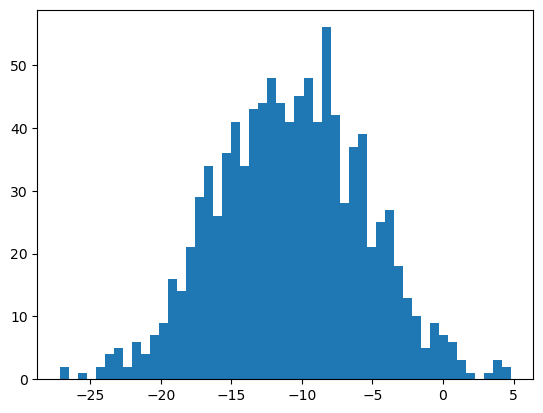

In [40]:
_, _, bars = plt.hist(pd_boot_data[0], bins = 50)

In [41]:
left_quant = (1 - 0.95)/2
right_quant = 1 - (1 - 0.95) / 2
quants = pd_boot_data.quantile([left_quant, right_quant])

In [42]:
p_1 = norm.cdf(
    x = 0, 
    loc = np.mean(boot_data), 
    scale = np.std(boot_data)
)
p_2 = norm.cdf(
    x = 0, 
    loc = -np.mean(boot_data), 
    scale = np.std(boot_data)
)
p_value = min(p_1, p_2) * 2

In [43]:
p_2

0.01974452610378238

In [44]:
quants[0]

0.025   -20.804348
0.975    -0.562980
Name: 0, dtype: float64

In [58]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_num = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_num)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

{'whiskers': [<matplotlib.lines.Line2D at 0x18bb9c00>,
 'caps': [<matplotlib.lines.Line2D at 0x18bba140>,
 'boxes': [<matplotlib.lines.Line2D at 0x18bb9960>],
 'medians': [<matplotlib.lines.Line2D at 0x18bba680>],
 'fliers': [<matplotlib.lines.Line2D at 0x18bba920>],
 'means': []}

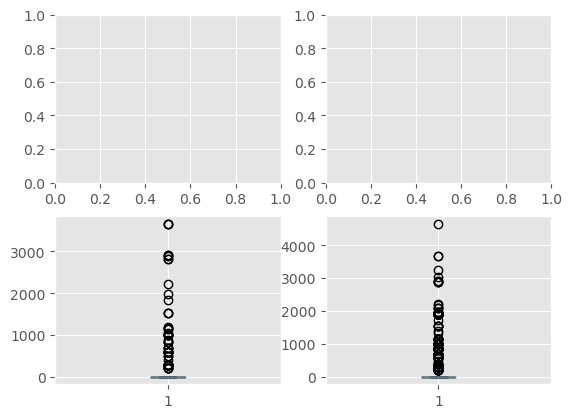

In [78]:

figure, [(ax1, ax2),(ax3,ax4)] = plt.subplots(2,2)
# ax1.boxplot(x = control_ARPPU)
# ax2.boxplot(x = test_ARPPU)
ax3.boxplot(x = control_ARPU)
ax4.boxplot(x = test_ARPU)

  0%|          | 0/1000 [00:00<?, ?it/s]

D:\Python\lib\site-packages\scipy\stats\_distn_infrastructure.py:2176: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


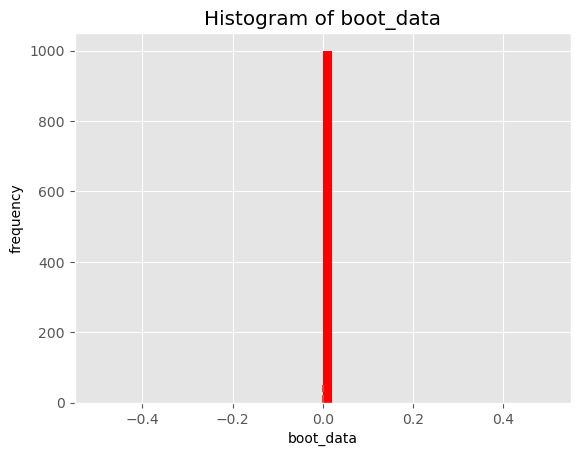

{'quants':          0
 0.025  0.0
 0.975  0.0,
 'p_value': nan}

In [74]:
get_bootstrap(control_ARPU, test_ARPU, statistic=np.nanmedian)

In [ ]:
get_bootstrap(control_ARPU, test_ARPU)

In [ ]:
sample_means_control = []
sample_means_test = []
for i in tqdm(range(1000)):
    sample_control = full_df.loc[full_df.grp =='A', 'rev'].sample(frac=1, replace=True)
    sample_test = full_df.loc[full_df.grp =='B', 'rev'].sample(frac=1, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_test.append(sample_test.mean())

# Plot the population
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
#count, bins, ignored = plt.hist(sample_control, 30, density=True)
plt.hist(sample_control, 30, density=True)
plt.title('Distribution of the control population')
plt.subplot(2,2,2)
plt.hist(sample_test, 30, density=True)
plt.title('Distribution of the test population')
plt.show()

# Q-Q plots for control and target groups
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
stats.probplot(sample_means_control, dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(sample_means_test, dist="norm", plot=plt)
plt.show()

# check for normality by Shapiro-Wilk test
sp = stats.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(sample_means_test)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)


In [ ]:
sp